In [1]:
suppressMessages(library(gsheet))
suppressMessages(library(EnvStats))
suppressMessages(library(ggplot2))
suppressMessages(library(data.table))
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))
suppressMessages(library(scales))
setwd("../../")
source("/workdir/omm35/paper_urine_cfrna/scripts/theme_ggplot_cfrna.R")

Warning message:
“package ‘gsheet’ was built under R version 4.2.2”
Warning message:
“package ‘EnvStats’ was built under R version 4.2.2”


load all data 

In [2]:
files = list.files(path = ".", recursive = TRUE, pattern="*_biotypes.tsv", full.names = TRUE)
biotypes_df= lapply(files,fread)

common_column <- "biotype"
biotypes_df <- Reduce(function(x, y) merge(x, y, by = common_column, all.x = TRUE), biotypes_df)
                      
                      
samples_after_qc=fread("metadata/QC_pass_samples.csv")
sample_names = intersect(samples_after_qc$sample_id,colnames(biotypes_df))
biotypes.df = biotypes_df  %>% select(all_of(c("biotype",sample_names)))
                      
master.biotypes.df = (as.data.frame(t(biotypes.df)))

column_names = master.biotypes.df[1,]
sample_names = rownames(master.biotypes.df)
master.biotypes.df = as.data.frame(apply(master.biotypes.df, 2, as.numeric))
master.biotypes.df$sample_id = sample_names

master.biotypes.df = master.biotypes.df[-1,]
names(master.biotypes.df)=column_names
colnames(master.biotypes.df)[ncol(master.biotypes.df)]="sample_id"
master.biotypes.df = master.biotypes.df %>% select(sample_id, everything())



master.biotypes.df = master.biotypes.df %>% left_join(samples_after_qc  %>% select(sample_id,reads_trimmed_filtered), by="sample_id")

                      

numeric_columns <- sapply(master.biotypes.df[-1], is.numeric)


master.biotypes.df_result <- master.biotypes.df
master.biotypes.df_result[,2:ncol(master.biotypes.df)] <- master.biotypes.df[, 2:ncol(master.biotypes.df)] / master.biotypes.df[, ncol(master.biotypes.df)] 
                      
                      
biotypes_df=master.biotypes.df_result  %>% select(-reads_trimmed_filtered)  
biotypes_df = biotypes_df %>% left_join(samples_after_qc %>% select(sample_id,biofluid), by="sample_id")
                    # Identify numeric columns (excluding the first column)
numeric_columns <- sapply(master.biotypes.df[-1], is.numeric)

# Divide numeric columns by the values in the last column
master.biotypes.df_result <- master.biotypes.df
master.biotypes.df_result[,2:ncol(master.biotypes.df)] <- master.biotypes.df[, 2:ncol(master.biotypes.df)] / master.biotypes.df[, ncol(master.biotypes.df)]
                      
                      biotypes_df = biotypes_df  %>% select(-sample_id)
biotypes_df_means <- biotypes_df %>%
  group_by(biofluid) %>%
  summarize(across(everything(), mean))

##calculating fractions of each mean

biotypes_df_fractions <- biotypes_df_means%>%
  group_by(biofluid) %>%
  rowwise() %>%
  mutate(across(everything(), ~ .x / sum(c_across()))) %>%
  ungroup()


biotypes_df_fractions = biotypes_df_fractions  %>% filter(!(biofluid=="ktx_urine"))




master.biotypes.df_means = as.data.frame(t(biotypes_df_fractions))
master.biotypes.df_means = master.biotypes.df_means  


colnames(master.biotypes.df_means)=master.biotypes.df_means[1,]
master.biotypes.df_means = master.biotypes.df_means[-1,]

master.biotypes.df_means = master.biotypes.df_means  %>%  rownames_to_column(var="biotype")
master.biotypes.df_means <- pivot_longer(master.biotypes.df_means,  cols= "aki_plasma":"healthy_urine",
                        names_to = "biofluid", values_to = "fraction")
master.biotypes.df_means$fraction = as.numeric(master.biotypes.df_means$fraction)



master.biotypes.df_means = master.biotypes.df_means %>% group_by(biofluid) %>% arrange(desc(fraction)) %>% slice(1:10)

master.biotypes.df_means = master.biotypes.df_means  %>% group_by(biofluid) %>% mutate(biofluid= biofluid, biotype="other", fraction=1-sum(fraction)) %>% 
distinct()%>% bind_rows(master.biotypes.df_means, .) 

In [46]:
# Load all TSV files matching the pattern *_biotypes.tsv from the current directory and its subdirectories.
files = list.files(path = ".", recursive = TRUE, pattern="*_biotypes.tsv", full.names = TRUE)
# Read each file into a data frame and store all data frames in a list.
biotypes_df= lapply(files, fread)

# Define a common column name for merging data frames.
common_column <- "biotype"
# Merge all data frames in the list by the common column, retaining all rows from the first data frame.
biotypes_df <- Reduce(function(x, y) merge(x, y, by = common_column, all.x = TRUE), biotypes_df)

# Read the QC pass samples metadata.
samples_after_qc = fread("metadata/QC_pass_samples.csv")
# Find common sample IDs between QC pass samples and the column names of the merged data frame.
sample_names = intersect(samples_after_qc$sample_id, colnames(biotypes_df))
# Select the 'biotype' column and columns corresponding to the common sample names from the merged data frame.
biotypes_df = biotypes_df %>% select(all_of(c("biotype", sample_names)))

# Transpose the data frame to make samples as rows and biotypes as columns.
master.biotypes.df = (as.data.frame(t(biotypes_df)))

# Extract column names and sample names from the transposed data frame.
column_names = master.biotypes.df[1,]
sample_names = rownames(master.biotypes.df)
# Convert all values to numeric, except for the sample ID column.
master.biotypes.df = as.data.frame(apply(master.biotypes.df, 2, as.numeric))
master.biotypes.df$sample_id = sample_names

# Remove the first row (which was used for column names) and set the extracted column names as the new column names.
master.biotypes.df = master.biotypes.df[-1,]
names(master.biotypes.df) = column_names
colnames(master.biotypes.df)[ncol(master.biotypes.df)] = "sample_id"
# Reorder columns to have 'sample_id' as the first column.
master.biotypes.df = master.biotypes.df %>% select(sample_id, everything())

# Join the QC metadata (reads trimmed and filtered) with the master data frame based on 'sample_id'.
master.biotypes.df = master.biotypes.df %>% left_join(samples_after_qc %>% select(sample_id, reads_trimmed_filtered), by = "sample_id")

# Prepare the master data frame for normalization by calculating fractions.
# Identify numeric columns, excluding 'sample_id'.
numeric_columns <- sapply(master.biotypes.df[-1], is.numeric)

# Create a result data frame and normalize numeric columns by the last column (reads trimmed and filtered).
master.biotypes.df_result <- master.biotypes.df
master.biotypes.df_result[,2:ncol(master.biotypes.df)] <- master.biotypes.df[, 2:ncol(master.biotypes.df)] / master.biotypes.df[, ncol(master.biotypes.df)]

# Remove the 'reads_trimmed_filtered' column and join the 'biofluid' information from QC samples.
biotypes_df = master.biotypes.df_result %>% select(-reads_trimmed_filtered)  
biotypes_df = biotypes_df %>% left_join(samples_after_qc %>% select(sample_id, biofluid), by = "sample_id")

# Select columns for analysis, excluding 'sample_id'.
biotypes_df = biotypes_df %>% select(-sample_id)
# Group by 'biofluid' and calculate the mean for each group across all columns.
biotypes_df_means <- biotypes_df %>%
  group_by(biofluid) %>%
  summarize(across(everything(), mean))

# Calculate fractions of each mean, normalized by the sum across rows for each 'biofluid'.
biotypes_df_fractions <- biotypes_df_means %>%
  group_by(biofluid) %>%
  rowwise() %>%
  mutate(across(everything(), ~ .x / sum(c_across()))) %>%
  ungroup()

# Filter out specific biofluid from the analysis.
biotypes_df_fractions = biotypes_df_fractions %>% filter(!(biofluid == "ktx_urine"))

# Transpose the data frame to have biofluids as columns and biotypes as rows.
master.biotypes.df_means = as.data.frame(t(biotypes_df_fractions))
master.biotypes.df_means = master.biotypes.df_means  


colnames(master.biotypes.df_means)=master.biotypes.df_means[1,]
master.biotypes.df_means = master.biotypes.df_means[-1,]

master.biotypes.df_means = master.biotypes.df_means  %>%  rownames_to_column(var="biotype")
master.biotypes.df_means <- pivot_longer(master.biotypes.df_means,  cols= "aki_plasma":"healthy_urine",
                        names_to = "biofluid", values_to = "fraction")
master.biotypes.df_means$fraction = as.numeric(master.biotypes.df_means$fraction)



master.biotypes.df_means = master.biotypes.df_means %>% group_by(biofluid) %>% arrange(desc(fraction)) %>% slice(1:10)

master.biotypes.df_means = master.biotypes.df_means  %>% group_by(biofluid) %>% mutate(biofluid= biofluid, biotype="other", fraction=1-sum(fraction)) %>% 
distinct()%>% bind_rows(master.biotypes.df_means, .) 



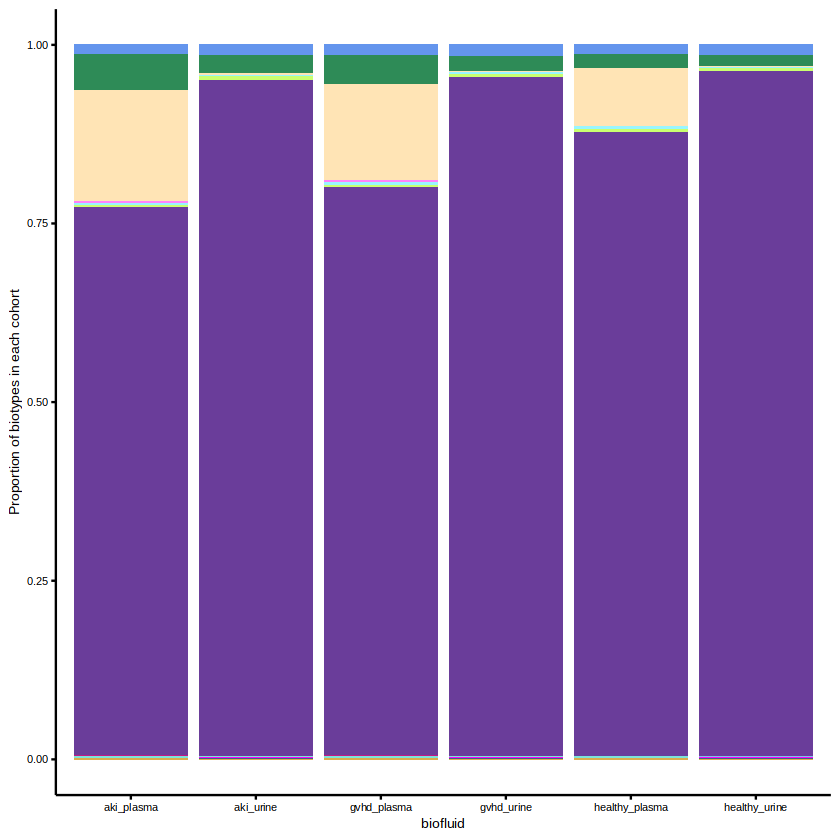

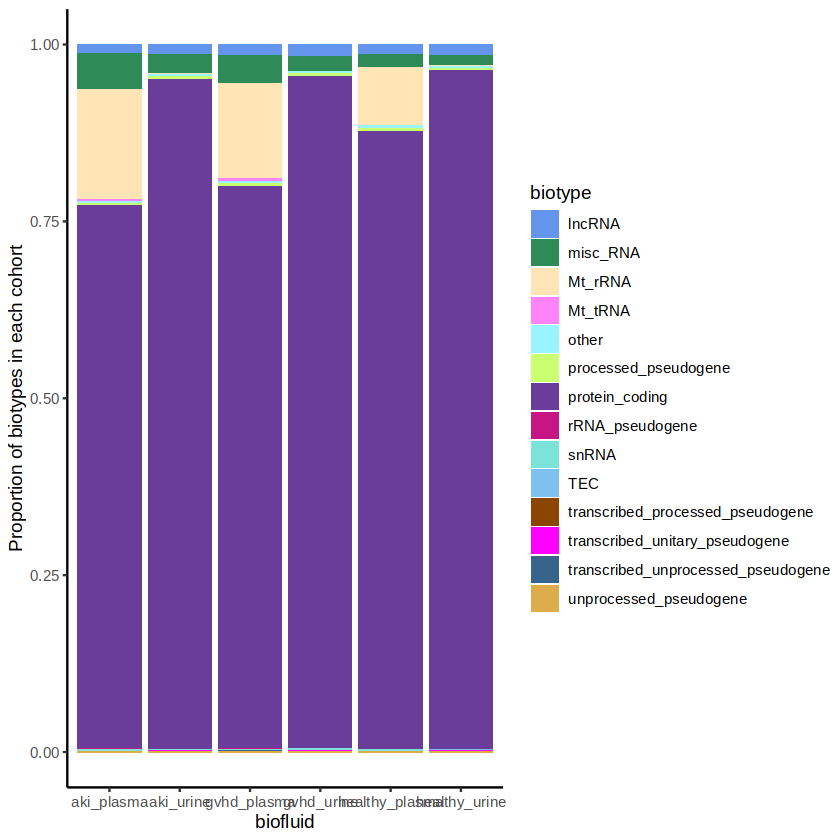

In [55]:
set.seed(106)

my_palette<-c('black','forestgreen', 'red2', 'orange', 'cornflowerblue', 
                'magenta', 'darkolivegreen4', 'indianred1', 'tan4', 'darkblue', 
                'mediumorchid1','firebrick4',  'yellowgreen', 'lightsalmon',
              'tan3',"tan1",'darkgray', 'wheat4', '#DDAD4B', 'chartreuse', 
                'seagreen1', 'moccasin', 'mediumvioletred', 'seagreen',
              'cadetblue1',"darkolivegreen1" ,"tan2" ,   "tomato3" , "#7CE3D8","gainsboro","gold1",
             "khaki2","darkturquoise", "steelblue4","skyblue2","orchid1","darkorange4","yellow4",
              "yellow3","dodgerblue2","deeppink1",
              "#6A3D9A"
             )

my_palette<-sample(my_palette)
master.biotypes.df_means$biofluid = str_replace(master.biotypes.df_means$biofluid,"clinical-","")
ggplot(master.biotypes.df_means, aes(biofluid,fraction, fill=biotype)) + geom_bar(position="fill", stat="identity")+
theme_classic()+scale_fill_manual(values = (my_palette))+ theme_classic()+theme(
          title = element_text(family="Helvetica", size=8, color='black'),
          axis.title = element_text(family="Helvetica", size=8, color='black'),
          axis.ticks = element_line(color='black'),
          axis.text = element_text(family="Helvetica", size=6, color='black'),
          legend.position = "non",
          legend.box.background = element_rect(),
)+ ylab("Proportion of biotypes in each cohort")

In [4]:
# df = master.biotypes.df_means  

In [2]:
df$biofluid=gsub(".*_","",df$biofluid)
df %>% group_by(biofluid, biotype) %>% summarize(mean=100*mean(fraction),sdev=100*sd(fraction))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

